In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import arviz as az
import pandas as pd
import ringdown
import seaborn as sns

sns.set_context('notebook')
sns.set_palette('husl')
sns.set_style('ticks')

First, let's load up some 16 kHz data.

In [3]:
fit = ringdown.Fit(model='mchi', modes=[(1, -2, 2, 2, 0), (1, -2, 2, 2, 1)])
fit.add_data(ringdown.Data.read('H-H1_GWOSC_16KHZ_R1-1126259447-32.hdf5', ifo='H1', kind='GWOSC'))
fit.add_data(ringdown.Data.read('L-L1_GWOSC_16KHZ_R1-1126259447-32.hdf5', ifo='L1', kind='GWOSC'))
fit.set_target(1126259462.4083147, ra=1.95, dec=-1.27, psi=0.82, duration=0.1)
fit.condition_data(flow=10.0)
fit.compute_acfs()

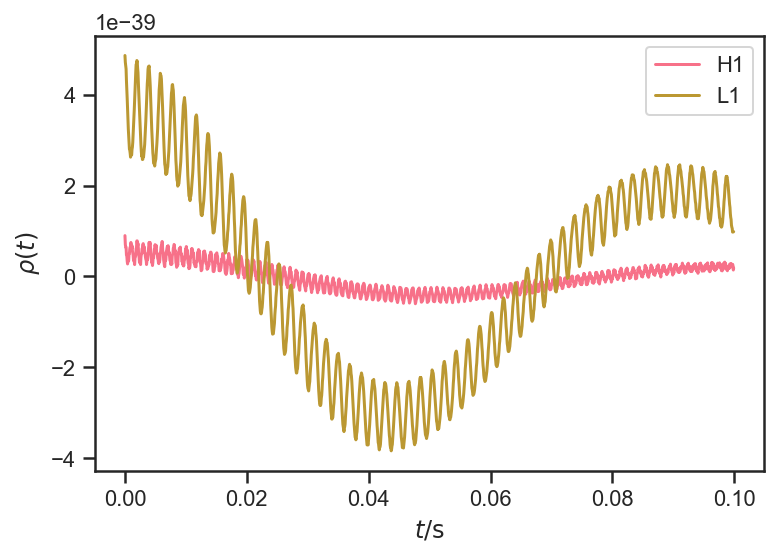

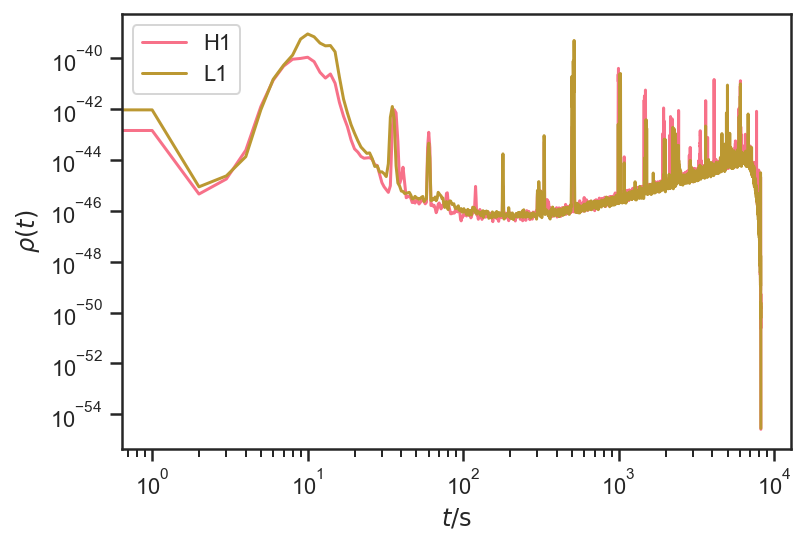

In [4]:
for k, acf in fit.acfs.items():
    acf.iloc[:fit.n_analyze].plot(label=k)
legend()
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$\rho(t)$')

figure()
for k, acf in fit.acfs.items():
    acf.to_psd().plot(label=k)
legend()
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$\rho(t)$')
xscale('log')
yscale('log')

Now let's generate some signals that look, very roughly, like the GW150914 ringdown.

SNR in L = 12.1


Text(0, 0.5, '$h(t)$')

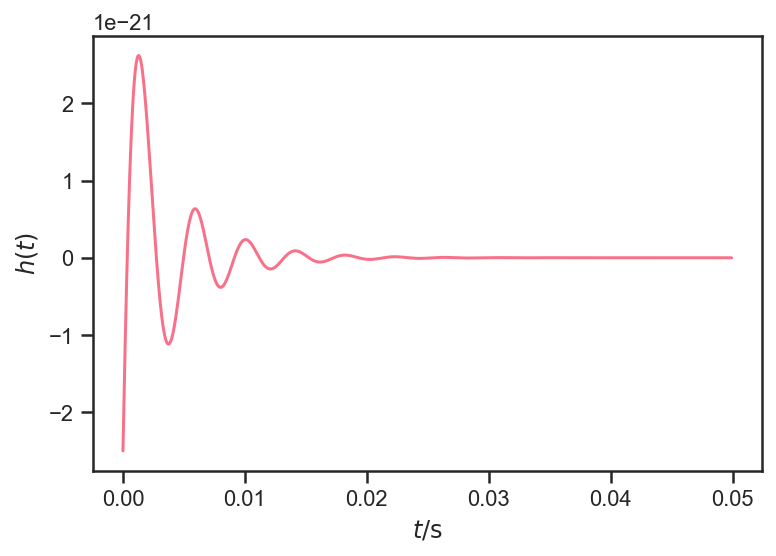

In [5]:
M = 70.0
chi = 0.7
f0, tau0 = ringdown.qnms.get_ftau(M, chi, 0)
f1, tau1 = ringdown.qnms.get_ftau(M, chi, 1)

ts = fit.analysis_data['L1'].time
ts = ts-ts[0]

A = 2.5e-21
h = A*(2*exp(-ts/tau1)*sin(2*pi*f1*ts) - exp(-ts/tau0)*cos(2*pi*f0*ts))
hw = fit.acfs['L1'].whiten(h)

print('SNR in L = {:.1f}'.format(sqrt(sum(square(hw)))))
plot(ts[:fit.n_analyze//2], h[:fit.n_analyze//2])
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h(t)$')

Now we want to check whether it matters if we whiten using the actual PSD above 1 kHz, or just something that is flat at around the ampltude of the PSD at 1 kHz.

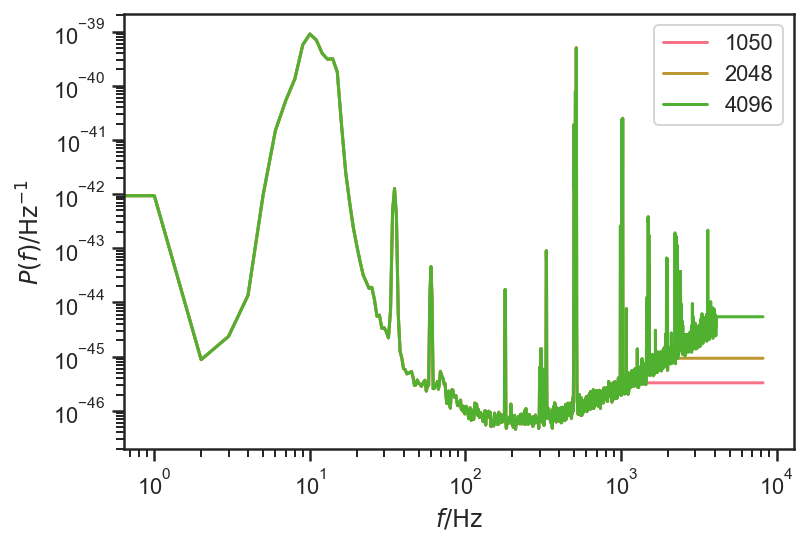

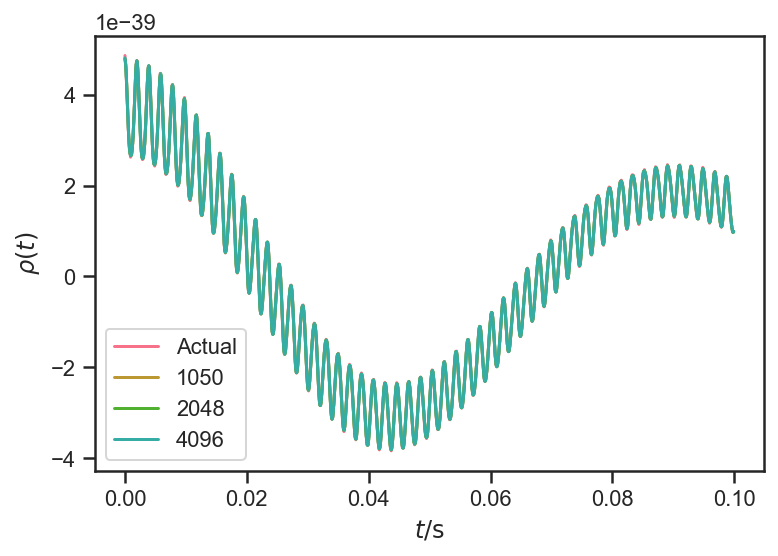

In [6]:
flat_freqs = [1050, 2048, 4096]

acfs_flat = {}
hws_flat = {}

for f_flat in flat_freqs:
    p_flat = fit.acfs['L1'].to_psd().copy()
    p_flat[p_flat.freq > f_flat] = p_flat.iloc[argmin(abs(p_flat.freq - f_flat))]

    acf_flat = p_flat.to_acf()
    acfs_flat[f_flat] = acf_flat
    
    hws_flat[f_flat] = acf_flat.whiten(h)

for f_flat, a_flat in acfs_flat.items():
    p_flat = a_flat.to_psd()
    
    p_flat.plot(label=f_flat)
    xscale('log')
    yscale('log')
    xlabel(r'$f / \mathrm{Hz}$')
    ylabel(r'$P(f) / \mathrm{Hz}^{-1}$')
legend(loc='best')

figure()
fit.acfs['L1'].iloc[:fit.n_analyze].plot(label='Actual')
for f_flat, acf_flat in acfs_flat.items():
    acf_flat.iloc[:fit.n_analyze].plot(label=f_flat)
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$\rho(t)$')
legend(loc='best')

SNR actual = 12.1
SNR flat(1050) = 12.54
SNR flat(2048) = 12.24
SNR flat(4096) = 12.04


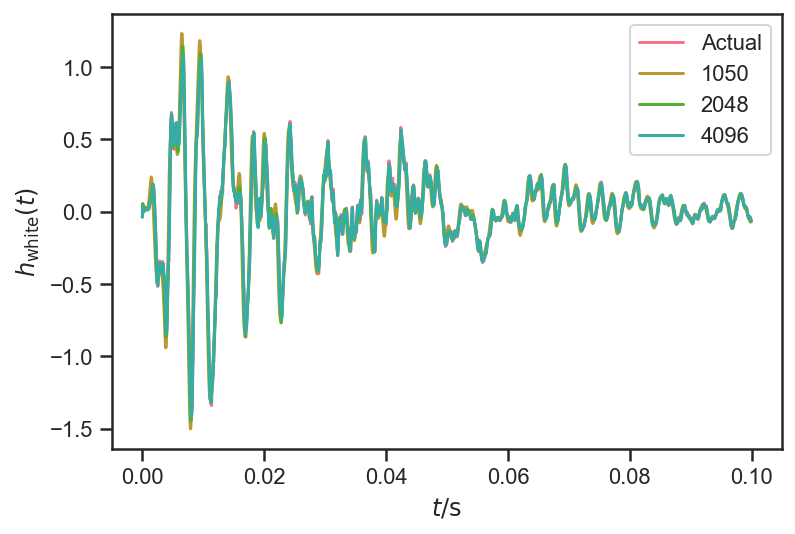

In [7]:
plot(ts, hw, label='Actual')
for f, hw_flat in hws_flat.items():
    plot(ts, hw_flat, label=f)
xlabel(r'$t / \mathrm{s}$')
ylabel(r'$h_\mathrm{white}(t)$')
legend(loc='best')

print('SNR actual = {:.1f}'.format(sqrt(sum(square(hw)))))
for f, hw_flat in hws_flat.items():
    print('SNR flat({:d}) = {:.2f}'.format(f, sqrt(sum(square(hw_flat)))))

In [8]:
M = 70.0
chi = 0.7
f0, tau0 = ringdown.qnms.get_ftau(M, chi, 0)
f1, tau1 = ringdown.qnms.get_ftau(M, chi, 1)

ts = fit.analysis_data['L1'].time
ts = ts-ts[0]

A = 2.5e-21
hp = A*(2*exp(-ts/tau1)*sin(2*pi*f1*ts) - exp(-ts/tau0)*cos(2*pi*f0*ts))
hc = A*(2*exp(-ts/tau1)*sin(2*pi*f1*ts+pi/2) - exp(-ts/tau0)*cos(2*pi*f0*ts+pi/2))

In [9]:
fit_zeros = fit.copy()
fits_zeros = {}
for ifo in fit_zeros.ifos:
    fit_zeros.data[ifo][:] = zeros_like(fit_zeros.data[ifo])
    fp, fc = fit_zeros.antenna_patterns[ifo]
    h = fp*hp + fc*hc
    i = fit_zeros.start_indices[ifo]
    fit_zeros.data[ifo].iloc[i:i+len(h)] = h
    fit_zeros.acfs = fit.acfs.copy()

In [10]:
for srate in [2048, 4096]: #, 8192]:
    print('Fitting srate = {:d}'.format(srate))
    f = fit_zeros.copy()
    ff = fit.copy()

    ds = int(round(16384 / srate))
    f.condition_data(flow=10, ds=ds)
    ff.condition_data(ds=ds)
    ff.compute_acfs()

    f.acfs = ff.acfs.copy()

    f.update_prior(flat_A=1, A_scale = 2.5e-21, M_min=35.0, M_max=140.0)

    try:
        r = az.from_netcdf('zero_result_{:d}_0p1.nc'.format(srate))
        f.result = r
    except:
        f.run()
        f.result.to_netcdf('zero_result_{:d}_0p1.nc'.format(srate))
    fits_zeros[srate] = f

Fitting srate = 2048
Fitting srate = 4096


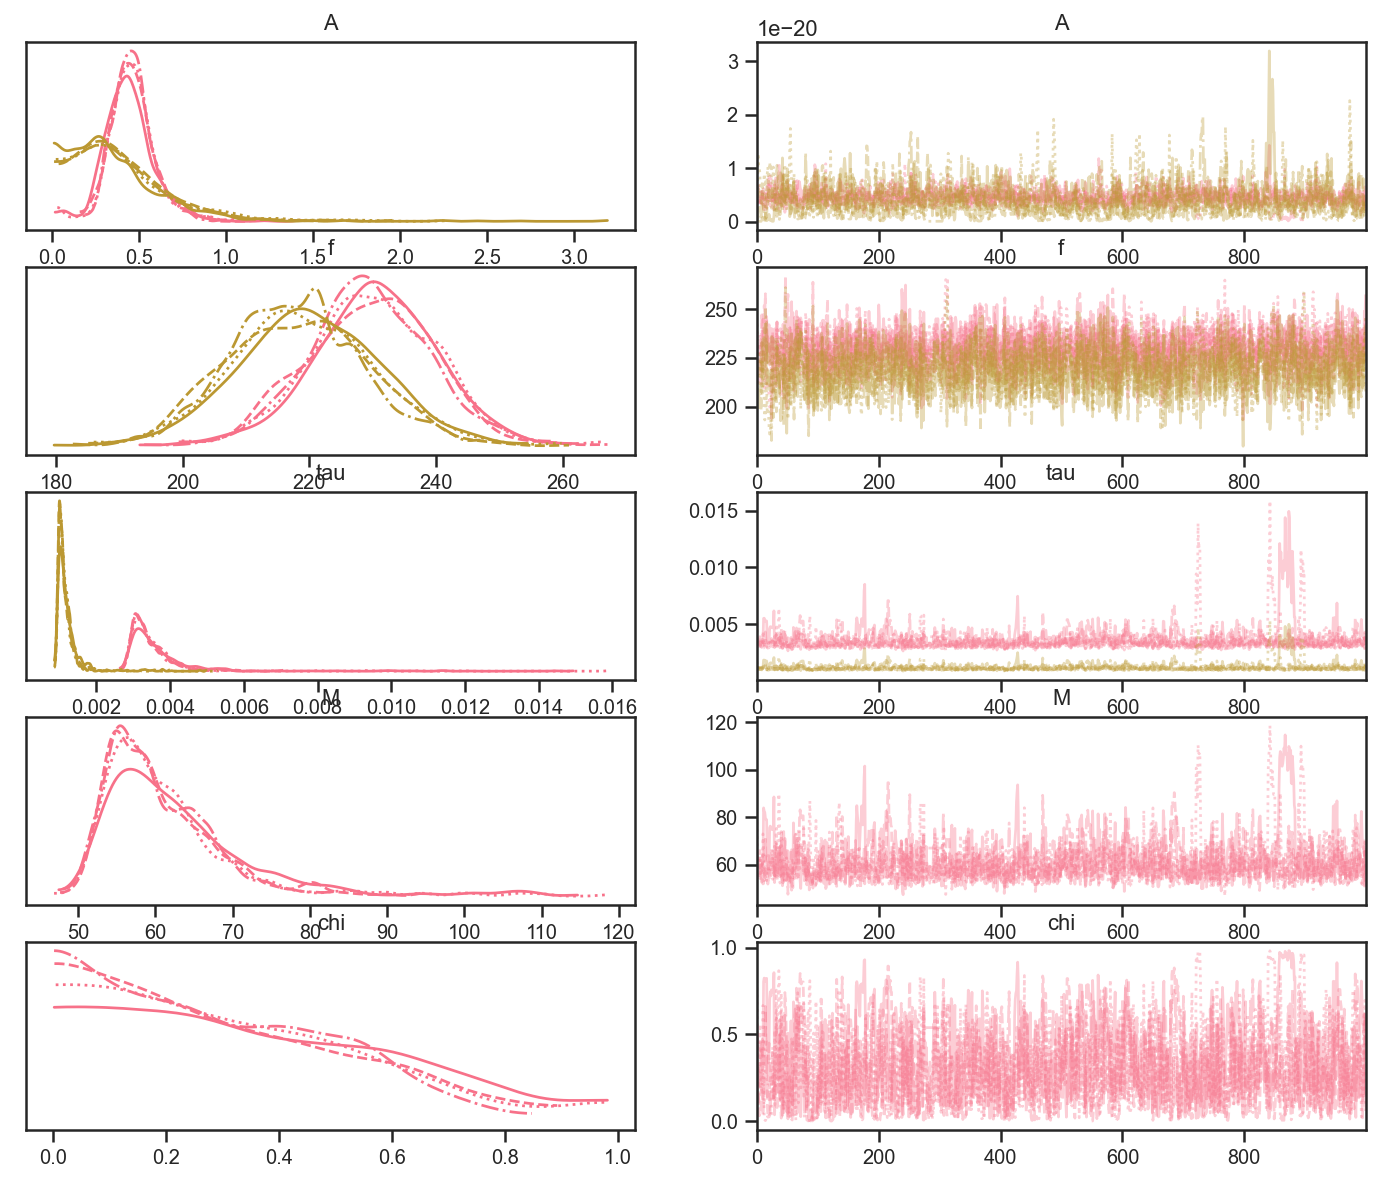

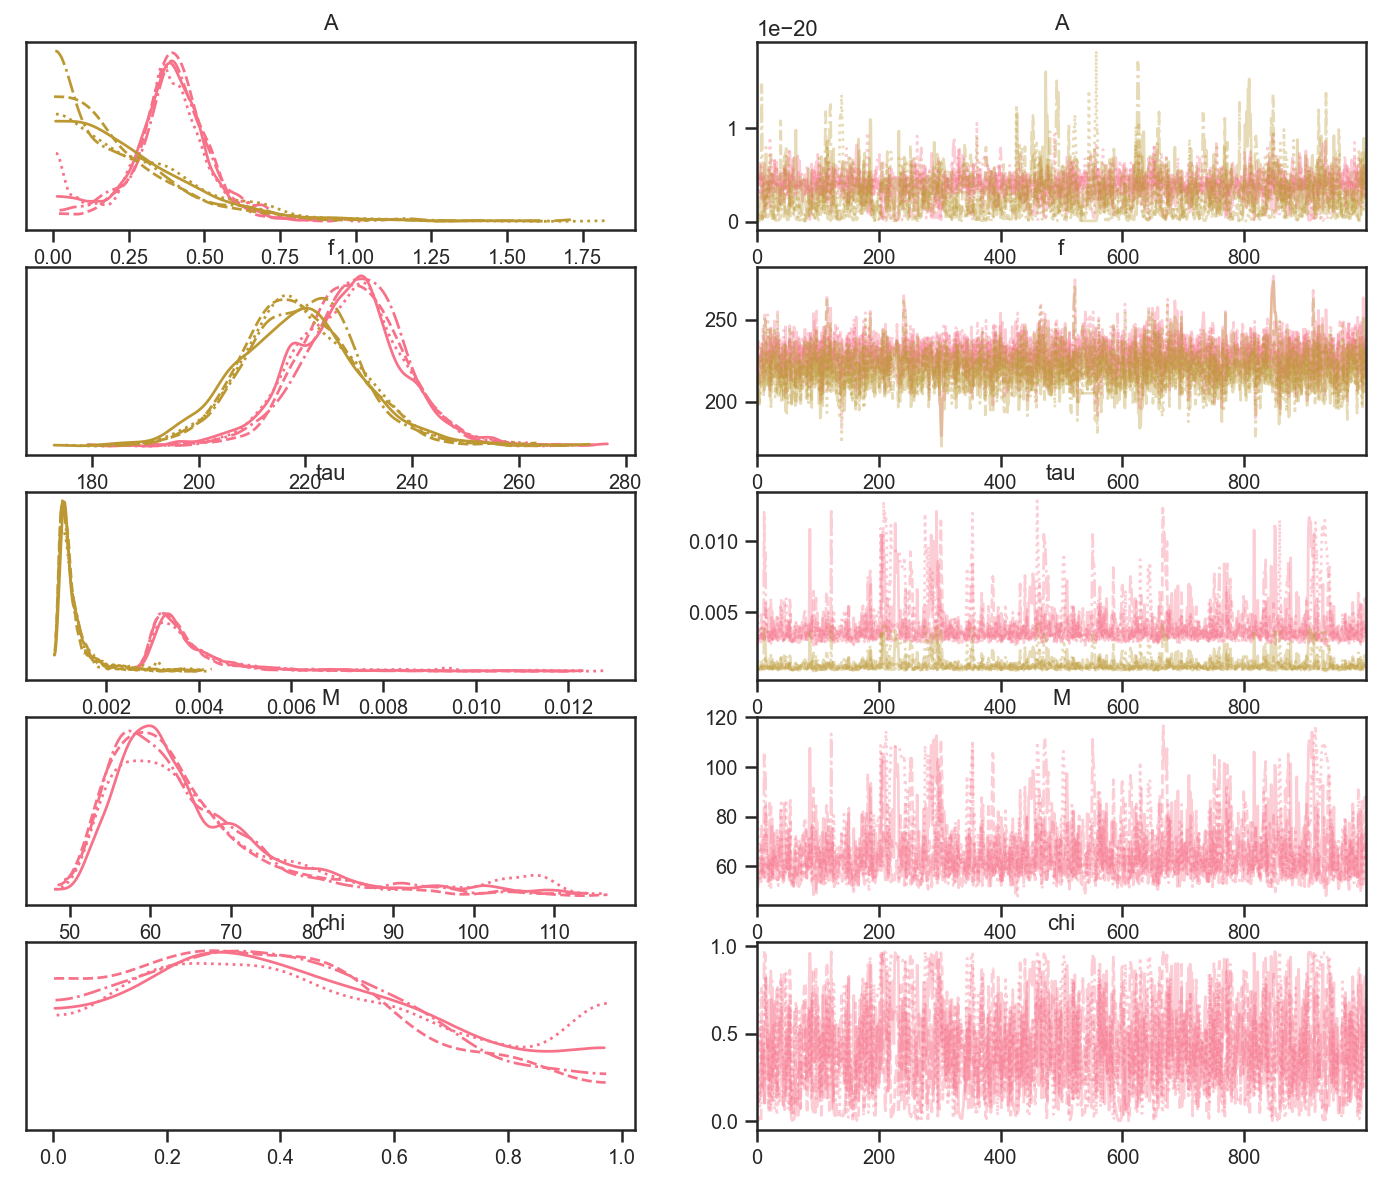

In [11]:
for s, f in fits_zeros.items():
    az.plot_trace(f.result, var_names=['A', 'f', 'tau', 'M', 'chi'])

In [12]:
df = pd.DataFrame({s: f.result.posterior.A[:,:,1].values.flatten() for s, f in fits_zeros.items()})

Text(0.5, 8.95999999999998, '$A_1$')

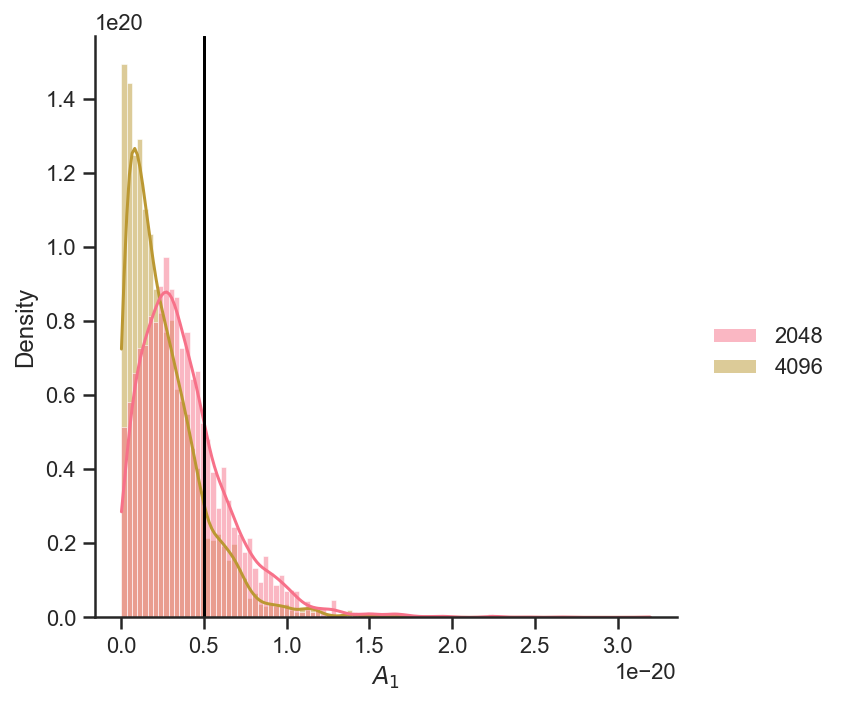

In [13]:
sns.displot(df, kde=True, stat='density')
axvline(2*A, color='k')
xlabel(r'$A_1$')

(1126259462.4229736,
 1126259462.4429736,
 -3.963312063911898e-21,
 1.7944604070404307e-21)

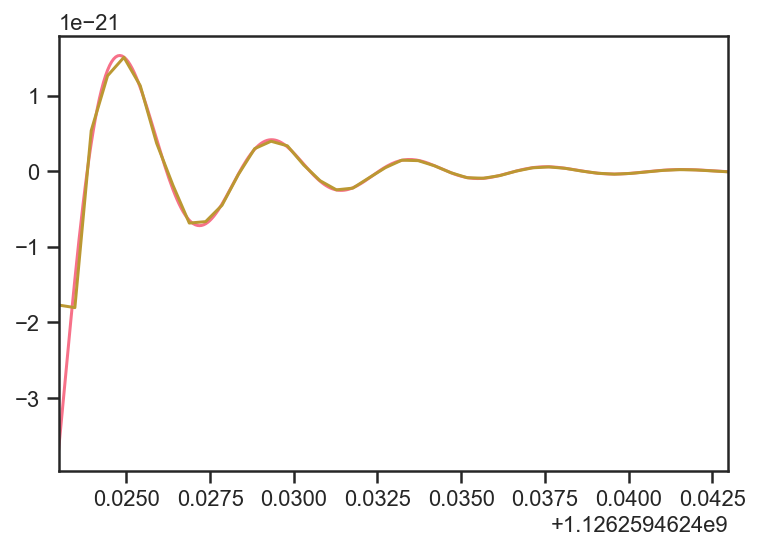

In [16]:
fit_zeros.analysis_data['H1'].plot()
fits_zeros[2048].analysis_data['H1'].plot()
axis(xmin=fit_zeros.analysis_data['H1'].time[0], xmax=fit_zeros.analysis_data['H1'].time[0]+0.02)